In [5]:
%matplotlib inline
import torch
import numpy as np
from collections import OrderedDict
import seaborn as sns
import os
import matplotlib.pyplot as plt
import scipy
import matplotlib

matplotlib.rc('axes', labelsize=14)
plt.rc('legend',fontsize=16) # using a size in points

def sum_all_the_dict(dicts):
    lengths = [len(d) for d in dicts]
    min_idx = np.argmin(lengths)
    assert len(dicts[min_idx]) == min(lengths)
    
    print('smallest length of dictionary: %d with length %d' % (min_idx, len(dicts[min_idx])))
    
    first_key = next(iter(dicts[0]))
    init_container = dicts[0][first_key][0]
    for idx, the_dict in enumerate(dicts):
#         for key in the_dict:
        for key in dicts[min_idx]:
            if idx == 0 and key == first_key:
                continue
            init_container = init_container.add(the_dict[key][0])
    return init_container

def change_name_table(table):
    # Change the names of Methods to display in the figure
    names_dict = OrderedDict([
        ('rnn_rank_rnn_aupr', 'Dropout FR'),
        ('rnn_rank_rf_aupr', 'Dropout FR'),
        ('rnn_rank_svc-rbf_aupr', 'Dropout FR'),
        ('rnn_rank_svc-linear_aupr', 'Dropout FR'),
        ('rf_rank_rnn_aupr', 'RF rank'),
        ('rf_rank_rf_aupr', 'RF rank'),
        ('rf_rank_svc-rbf_aupr', 'RF rank'),
        ('rf_rank_svc-linear_aupr', 'RF rank'),
        ('zero_rank_rnn_aupr', 'Zero rank'),
        ('zero_rank_rf_aupr', 'Zero rank'),
        ('zero_rank_svc-rbf_aupr', 'Zero rank'),
        ('zero_rank_svc-linear_aupr', 'Zero rank'),
        ('random_rank_rnn_aupr', 'Random rank'),
        ('random_rank_rf_aupr', 'Random rank'),
        ('random_rank_svc-rbf_aupr', 'Random rank'),
        ('random_rank_svc-linear_aupr', 'Random rank'),
    ])

    table['order'] = -1
    for idx, key in enumerate(names_dict):
        table.loc[table[table['Methods'] == key].index, 'order'] = idx
        table.loc[table[table['Methods'] == key].index, 'Methods'] = names_dict[key]
    table.sort_values('order', inplace=True)
    return table

def cal_rnn_rf_sig_in_table(the_table, table_name='rnn', num_features=1):
    return cal_sig_in_table(the_table, table_name=table_name, compared='rf', num_features=num_features)

def cal_rnn_zero_sig_in_table(the_table, table_name='rnn', num_features=1):
    return cal_sig_in_table(the_table, table_name=table_name, compared='zero', num_features=num_features)

def cal_sig_in_table(the_table, table_name='rnn', compared='rf', num_features=1):
    tmp = the_table[the_table['Methods'] == 'rnn_rank_%s_aupr' % table_name]
    tmp = tmp[tmp['Number of features'] == num_features]

    tmp2 = the_table[the_table['Methods'] == '%s_rank_%s_aupr' % (compared, table_name)]
    tmp2 = tmp2[tmp2['Number of features'] == num_features]
    
    if len(tmp) == 0 or len(tmp2) == 0:
        return 1., 0.
    
    max_value = max(max(tmp['Test AUPR']), max(tmp['Test AUPR']))

#     return scipy.stats.wilcoxon(tmp['Test AUPR'], tmp2['Test AUPR']).pvalue, max_value
    return scipy.stats.ranksums(tmp['Test AUPR'], tmp2['Test AUPR']).pvalue, max_value
#     return scipy.stats.ttest_ind(tmp['Test AUPR'], tmp2['Test AUPR']).pvalue, max_value
#     return scipy.stats.ttest_rel(tmp['Test AUPR'], tmp2['Test AUPR']).pvalue, max_value


def plot_figs(self, table_name, ax=None, title=None, test_wilcoxn=False):
    allow_method_names = ['%s_%s_aupr' % (k, table_name) 
                          for k in ['rnn_rank', 'zero_rank', 'random_rank', 'rf_rank', 'marginal_rank']]
    
    plot_table = self.get_pandas_table(allow_method_names)
    
    if ax is None:
        fig, ax = plt.subplots()
    
    if test_wilcoxn:
        for sig_method, symbol, height in [(cal_rnn_rf_sig_in_table, '*', 0.45), 
#                                            (cal_rnn_zero_sig_in_table, 'o', 0.48)
                                          ]:
            for nf in [1, 2, 5, 10, 15, 20, 30, 37]:
#                 if nf == 37 and table_name == 'svc-rbf' and sig_method == cal_rnn_rf_sig_in_table:
#                     import pdb; pdb.set_trace()
                pvalue, max_value = sig_method(plot_table, table_name, num_features=nf)
                if pvalue < 0.1: # 1-side test
                    print(pvalue, nf, table_name)
                    ax.text(nf, height, symbol, ha='center', va='bottom',)

    plot_table = change_name_table(plot_table)

    ax = sns.tsplot(time=self.x_name, value=self.val_name, ax=ax,
                    unit="unit", condition=self.line_name,
                    data=plot_table, err_style="ci_bars", interpolate=True)
    ax.set_ylim(0.15, 0.5)
    ax.set_xlim(0, 38)
    if title is not None:
        ax.set_title(title, fontsize=20)
    
    return ax


def sum_all_container_by_filenames(filenames):
    tmp = []
    for f in filenames:
        path = os.path.join('../results/ClassificationONPLoader', f)
        container_dicts, _ = torch.load(path)
        tmp.append(container_dicts)
    return sum_all_the_dict(tmp)

smallest length of dictionary: 0 with length 5


/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


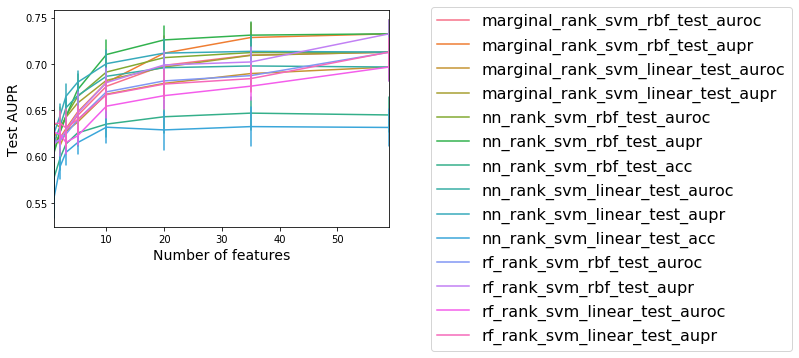

In [8]:
the_container = sum_all_container_by_filenames([
    '0105-marginal_rank-joint_test.pth',
    '0105-r0.01-nn_rank-joint_test.pth',
    '0105-rf_rank-joint_test.pth',
])
the_container.set_names('Test AUPR', 'Number of features', 'Methods')
the_container.plot_figs()
# plot_figs(the_container, table_name='svm_rbf_test', ax=None, title=None, test_wilcoxn=False)
plt.legend(bbox_to_anchor=(1.1, 1.05))

'%s_%s_aupr' % (k, table_name) 
                          for k in ['rnn_rank', 'zero_rank', 'random_rank', 'rf_rank', 'marginal_rank']]

smallest length of dictionary: 0 with length 5


/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


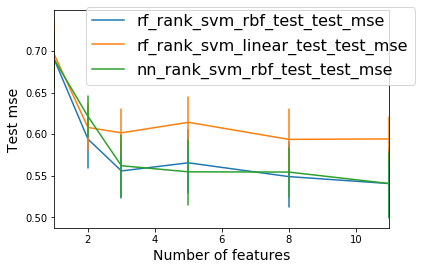

In [34]:
the_container = sum_all_container_by_filenames([
    '0105-rf_rank-joint_test.pth',
    '0105-r0.1-nn_rank-svm_rbf_test.pth',
#     '0105-r1-nn_rank-svm_rbf_test.pth',
])
the_container.set_names('Test mse', 'Number of features', 'Methods')
the_container.plot_figs()
plt.legend(bbox_to_anchor=(1.1, 1.05))

smallest length of dictionary: 0 with length 5


/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


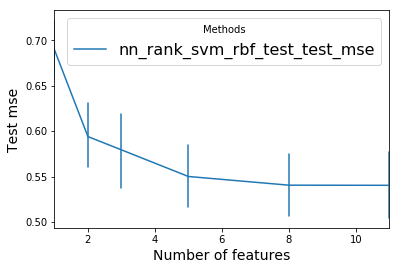

In [24]:
the_container = sum_all_container_by_filenames([
#     '0105-r0.1-joint_rank-svm_rbf_test.pth',
    '0105-r0.01-nn_rank-svm_rbf_test.pth',
#     '0105-r1-nn_rank-svm_rbf_test.pth',
])
the_container.set_names('Test mse', 'Number of features', 'Methods')
the_container.plot_figs()

smallest length of dictionary: 0 with length 5


/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


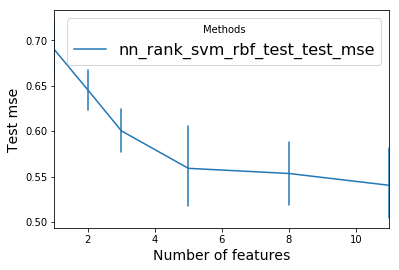

In [25]:
the_container = sum_all_container_by_filenames([
#     '0105-r0.1-joint_rank-svm_rbf_test.pth',
#     '0105-r0.01-nn_rank-svm_rbf_test.pth',
    '0105-r1-nn_rank-svm_rbf_test.pth',
])
the_container.set_names('Test mse', 'Number of features', 'Methods')
the_container.plot_figs()

1.41330851969e-07 1 rnn
0.0766370896777 1 rf
0.0404041195882 2 rf
2.361450777e-09 1 svc-rbf
2.6699457202e-08 1 svc-linear
0.0268855118534 5 svc-linear
0.000635507924247 10 svc-linear
0.00964079045934 15 svc-linear


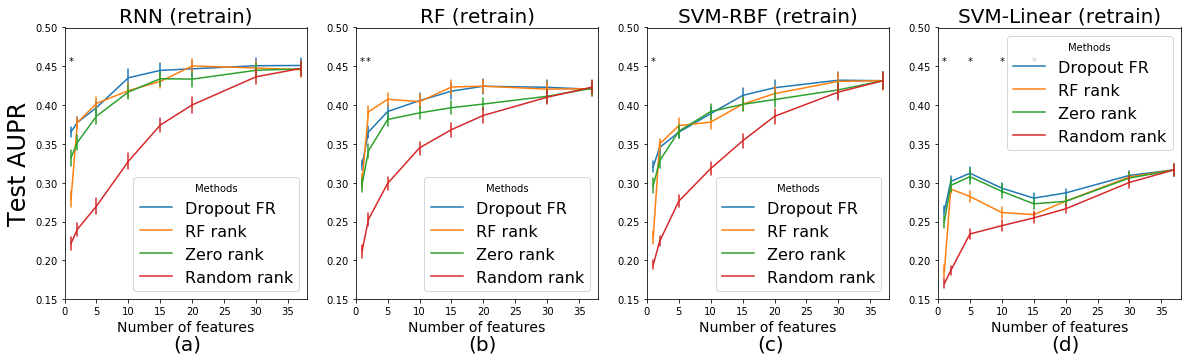

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
plot_figs(the_container, ax=axes[0], title='RNN (retrain)', table_name='rnn', test_wilcoxn=True)
plot_figs(the_container, ax=axes[1], title='RF (retrain)', table_name='rf', test_wilcoxn=True)
plot_figs(the_container, ax=axes[2], title='SVM-RBF (retrain)', table_name='svc-rbf', test_wilcoxn=True)
plot_figs(the_container, ax=axes[3], title='SVM-Linear (retrain)', table_name='svc-linear', test_wilcoxn=True)
fig.text(0.21, 0., '(a)', ha='center', va='center', fontsize=20)
fig.text(0.415, 0., '(b)', ha='center', va='center', fontsize=20)
fig.text(0.615, 0., '(c)', ha='center', va='center', fontsize=20)
fig.text(0.82, 0., '(d)', ha='center', va='center', fontsize=20)
axes[0].set_ylabel('Test AUPR', fontsize=24)
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[3].set_ylabel('')
fig.savefig('physionet_rank_retrain_split.eps', format='eps', dpi=300, bbox_inches='tight')

In [6]:
the_container_not_reuse = sum_all_container_by_filenames([
#     '1103-gpu-reuse-rnn-zero-0.001-rnn_rank-joint_test.pth',
#     '1103-reuse-rnn-zero-0.01-rnn_rank-joint_test.pth',
#     '1104-not-reuse-0.1-rnn_rank-joint_test.pth',
    '1104-not-reuse-0.01-rnn_rank-joint_test.pth',
    '1104-not-reuse-zero_rank-joint_test.pth',
    '1104-not-reuse-0.1-rf_rank-joint_test.pth',
    '1104-not-reuse-random_rank-joint_test.pth',
])
the_container_not_reuse.set_names('Test AUPR', 'Number of features', 'Methods')

smallest length of dictionary: 0 with length 20


smallest length of dictionary: 0 with length 20
smallest length of dictionary: 0 with length 20
2.610423803e-05 1 rnn


/home/zzzace2000/anaconda2/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


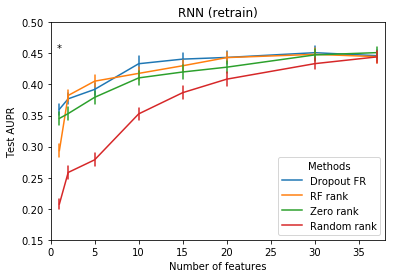

In [4]:
other_container_20_40 = sum_all_container_by_filenames([
    '1104-not-reuse-0.01-20-40-rnn_rank-rnn_test.pth',
    '1104-not-reuse-0.01-20-40-rnn_rank-sklearn_test.pth',
    '1104-not-reuse-0.01-20-40-rf_rank-rnn_test.pth',
    '1104-not-reuse-20-40-rf_rank-sklearn_test.pth',
    '1104-not-reuse-20-40-random_rank-rnn_test.pth',
    '1104-not-reuse-20-40-random_rank-sklearn_test.pth',
    '1104-not-reuse-0.01-20-40-zero_rank-rnn_test.pth',
    '1104-not-reuse-20-40-zero_rank-sklearn_test.pth',
])
the_container_not_reuse = sum_all_container_by_filenames([
#     '1103-gpu-reuse-rnn-zero-0.001-rnn_rank-joint_test.pth',
#     '1103-reuse-rnn-zero-0.01-rnn_rank-joint_test.pth',
#     '1104-not-reuse-0.1-rnn_rank-joint_test.pth',
    '1104-not-reuse-0.01-rnn_rank-joint_test.pth',
    '1104-not-reuse-zero_rank-joint_test.pth',
    '1104-not-reuse-0.1-rf_rank-joint_test.pth',
    '1104-not-reuse-random_rank-joint_test.pth',
])
joint1_40_container = the_container_not_reuse.add(other_container_20_40)
joint1_40_container.set_names('Test AUPR', 'Number of features', 'Methods')
plot_figs(joint1_40_container, title='RNN (retrain)', table_name='rnn', test_wilcoxn=True)


KeyError: 'Methods'

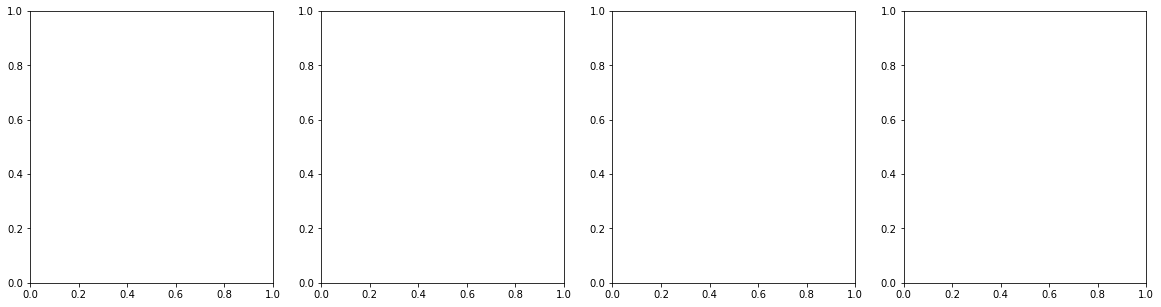

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
plot_figs(the_container_not_reuse, ax=axes[0], title='RNN prediction', table_name='rnn', test_wilcoxn=True)
plot_figs(the_container_not_reuse, ax=axes[1], title='RF prediction', table_name='rf', test_wilcoxn=True)
plot_figs(the_container_not_reuse, ax=axes[2], title='SVM (RBF) prediction', table_name='svc-rbf', test_wilcoxn=True)
plot_figs(the_container_not_reuse, ax=axes[3], title='SVM (linear) prediction', table_name='svc-linear', test_wilcoxn=True)
axes[3].legend(bbox_to_anchor=(1, 0.88))
fig.savefig('physionet_rank_retrain.eps', format='eps', dpi=300, bbox_inches='tight')

## Plot jointly with zeroing the features / retrain

smallest length of dictionary: 0 with length 90
4.80839945615e-15 1 rnn
0.00041944095196 10 rnn
2.610423803e-05 1 rnn


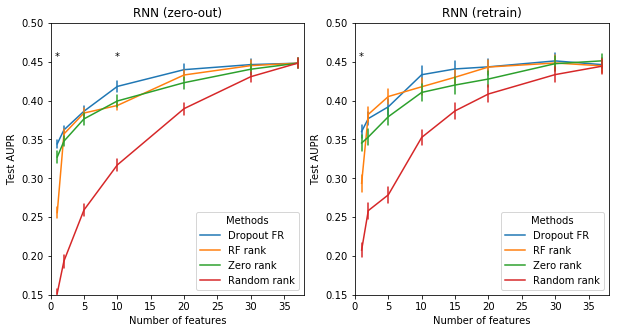

In [8]:
the_container = sum_all_container_by_filenames([
#     '1103-gpu-reuse-rnn-zero-0.001-rnn_rank-joint_test.pth',
    '1103-reuse-rnn-zero-0.01-rnn_rank-joint_test.pth',
#     '1103-reuse-rnn-zero-0.1-rnn_rank-joint_test.pth',
    '1103-reuse-rnn-zero-zero_rank-joint_test.pth',
    '1029-reuse-rnn-zero-rf_rank-joint_test.pth',
    '1029-reuse-rnn-zero-random_rank-joint_test.pth',
])
the_container.set_names('Test AUPR', 'Number of features', 'Methods')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_figs(the_container, ax=axes[0], title='RNN (zero-out)', table_name='rnn', test_wilcoxn=True)
plot_figs(joint1_40_container, ax=axes[1], title='RNN (retrain)', table_name='rnn', test_wilcoxn=True)
fig.savefig('physionet_both_rnn.eps', format='eps', dpi=300, bbox_inches='tight')

## Create subplots for the (a), (b), (c), (d)

0.00170214983386 1 rnn
0.00430072129974 1 rf
0.00378830373571 2 rf
2.81021969264e-15 1 svc-rbf
3.19719995268e-14 1 svc-linear
0.00164935469561 10 svc-linear


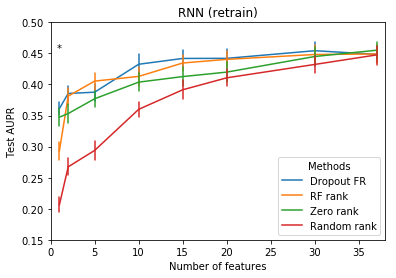

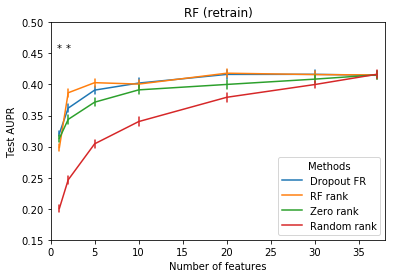

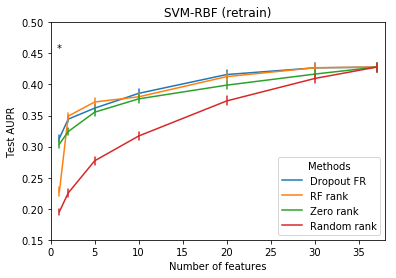

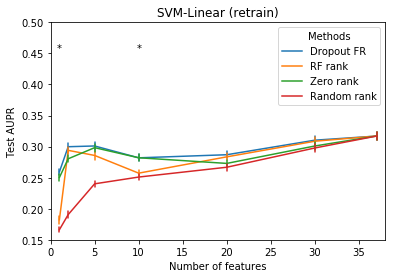

In [158]:
plot_figs(the_container_not_reuse, title='RNN (retrain)', table_name='rnn', test_wilcoxn=True)
plt.savefig('physionet_retrain_rank_a_rnn.eps', format='eps', dpi=300, bbox_inches='tight')
plot_figs(the_container, title='/home/zzzace2000/Googledrive/Lab/nl_markov_network/exp/feature
/home/zzzace2000/Googledrive/Lab/nl_markov_network/exp/physionet', table_name='rf', test_wilcoxn=True)
plt.savefig('physionet_retrain_rank_b_svmrf.eps', format='eps', dpi=300, bbox_inches='tight')
plot_figs(the_container, title='SVM-RBF (retrain)', table_name='svc-rbf', test_wilcoxn=True)
plt.savefig('physionet_retrain_rank_c_svmrbf.eps', format='eps', dpi=300, bbox_inches='tight')
plot_figs(the_container, title='SVM-Linear (retrain)', table_name='svc-linear', test_wilcoxn=True)
plt.savefig('physionet_retrain_rank_d_svmlin.eps', format='eps', dpi=300, bbox_inches='tight')

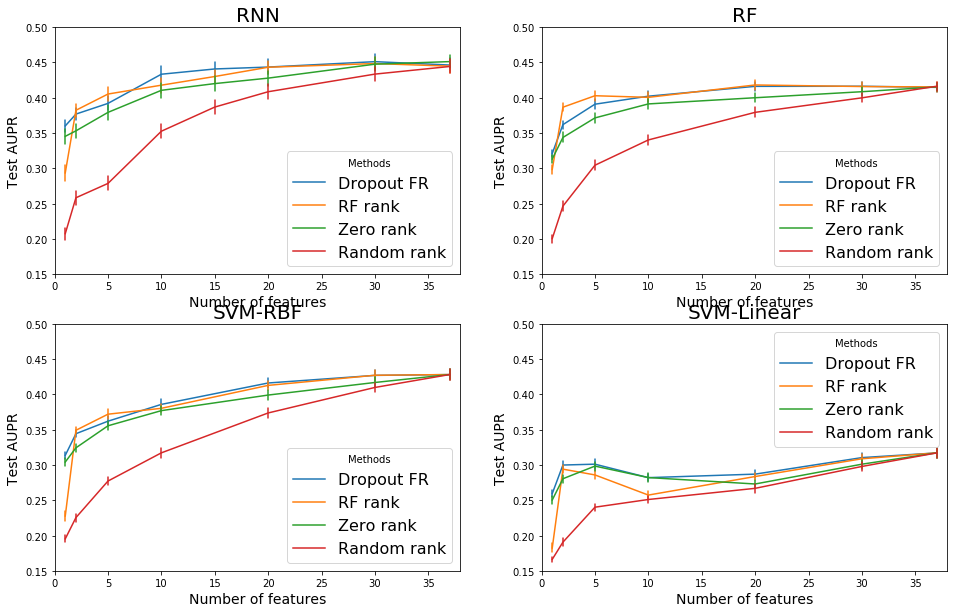

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
plot_figs(joint1_40_container, ax=axes[0, 0], title='RNN', table_name='rnn', test_wilcoxn=False)
plot_figs(the_container, ax=axes[0, 1], title='RF', table_name='rf', test_wilcoxn=False)
plot_figs(the_container, ax=axes[1, 0], title='SVM-RBF', table_name='svc-rbf', test_wilcoxn=False)
plot_figs(the_container, ax=axes[1, 1], title='SVM-Linear', table_name='svc-linear', test_wilcoxn=False)
# fig.text(0.21, 0., '(a)', ha='center', va='center', fontsize=20)
# fig.text(0.415, 0., '(b)', ha='center', va='center', fontsize=20)
# fig.text(0.615, 0., '(c)', ha='center', va='center', fontsize=20)
# fig.text(0.82, 0., '(d)', ha='center', va='center', fontsize=20)
# fig.savefig('physionet_retrain_rank.eps', format='eps', dpi=300, bbox_inches='tight')

In [29]:
rnn_table = the_container.get_pandas_table(allow_method_names=[
    'rnn_rank_rnn_aupr', 'zero_rank_rnn_aupr', 'random_rank_rnn_aupr', 'rf_rank_rnn_aupr'])

In [31]:
import scipy

num_features = 1
tmp = rnn_table[rnn_table['Methods'] == 'rnn_rank_rnn_aupr']
tmp = tmp[tmp['Number of features'] == num_features]

tmp2 = rnn_table[rnn_table['Methods'] == 'rf_rank_rnn_aupr']
tmp2 = tmp2[tmp2['Number of features'] == num_features]

scipy.stats.wilcoxon(tmp['Test AUPR'], tmp2['Test AUPR']).pvalue < 0.1

True

In [20]:
def cal_sig_in_table(table_name='rnn', num_features=1):
    allow_method_names = ['%s_%s_aupr' % (k, table_name) 
                          for k in ['rnn_rank', 'zero_rank', 'random_rank', 'rf_rank']]
    rnn_table = the_container.get_pandas_table(allow_method_names)
    
    tmp = rnn_table[rnn_table['Methods'] == 'rnn_rank_%s_aupr' % table_name]
    tmp = tmp[tmp['Number of features'] == num_features]

    tmp2 = rnn_table[rnn_table['Methods'] == 'rf_rank_%s_aupr' % table_name]
    tmp2 = tmp2[tmp2['Number of features'] == num_features]

    return scipy.stats.wilcoxon(tmp['Test AUPR'], tmp2['Test AUPR']).pvalue
cal_sig_in_table('rf', num_features=5)

0.15781136896845493

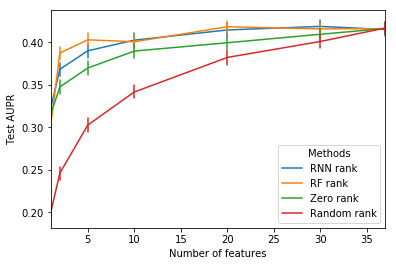

In [14]:
plot_figs(the_container, allow_method_names=['rf_rank_rf_aupr', 'rnn_rank_rf_aupr', 
                                             'random_rank_rf_aupr', 'zero_rank_rf_aupr'])

RuntimeError: Invalid input data for tsplot.

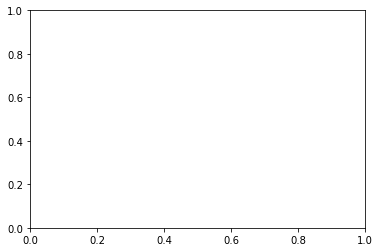

In [15]:
plot_figs(the_container, allow_method_names=['rf_rank_svm-rbf_aupr', 'rnn_rank_svm-rbf_aupr', 
                                             'random_rank_svm-rbf_aupr', 'zero_rank_svm-rbf_aupr'])

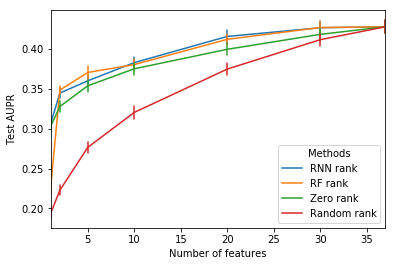

In [16]:
plot_figs(the_container, allow_method_names=['rf_rank_svc-rbf_aupr', 'rnn_rank_svc-rbf_aupr', 
                                             'random_rank_svc-rbf_aupr', 'zero_rank_svc-rbf_aupr'])

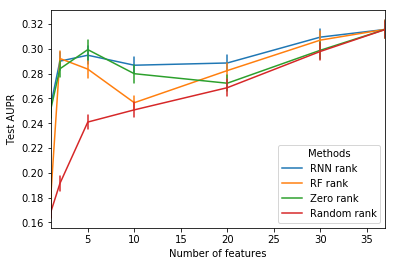

In [17]:
plot_figs(the_container, allow_method_names=['rf_rank_svc-linear_aupr', 'rnn_rank_svc-linear_aupr', 
                                             'random_rank_svc-linear_aupr', 'zero_rank_svc-linear_aupr'])

## Calculate the aupr / auroc

In [30]:
perf_container = sum_all_the_dict([rnn_container_dict])
perf_container.set_names('a', 'b', 'c')
perf_table = perf_container.get_pandas_table()

smallest length of dictionary: 0 with length 90


In [35]:
tmp = perf_table[perf_table['b'] == 37]
for method in ['rf', 'rnn', 'svc-linear', 'svc-rbf']:
    tmp2 = tmp[tmp['c'] == 'rnn_rank_%s_aupr' % method]
    print method, '%.3f' % tmp2['a'].mean(), '%.3f' % tmp2['a'].std()

rf 0.415 0.062
rnn 0.448 0.063
svc-linear 0.317 0.063
svc-rbf 0.428 0.070


In [36]:
tmp = perf_table[perf_table['b'] == 37]
for method in ['rf', 'rnn', 'svc-linear', 'svc-rbf']:
    tmp2 = tmp[tmp['c'] == 'rnn_rank_%s_auroc' % method]
    print method, '%.3f' % tmp2['a'].mean(), '%.3f' % tmp2['a'].std()

rf 0.796 0.023
rnn 0.808 0.026
svc-linear 0.709 0.030
svc-rbf 0.790 0.024


## Plot the figures

In [84]:
final_container = sum_all_the_dict([rf_container_dict, rnn_container_dict, random_container_dict, 
                                    zero_container_dict])

smallest length of dictionary: 3 with length 89


In [85]:
final_container.set_names('Test AUPR', 'Number of features', 'Methods')

## Compare in RNN

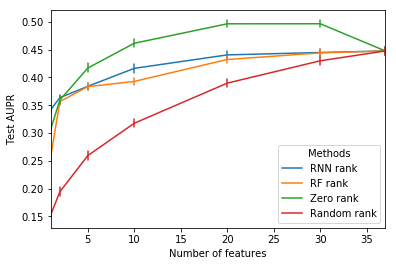

In [86]:
final_container.set_names('Test AUPR', 'Number of features', 'Methods')
plot_figs(final_container, allow_method_names=['rf_rank_rnn_aupr', 'rnn_rank_rnn_aupr', 
                                               'random_rank_rnn_aupr', 'zero_rank_rnn_aupr'])

## Compare with Random Forest

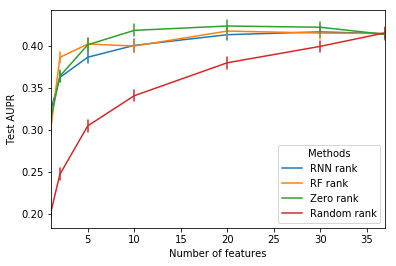

In [87]:
plot_figs(final_container, allow_method_names=['rf_rank_rf_aupr', 'rnn_rank_rf_aupr', 
                                               'random_rank_rf_aupr', 'zero_rank_rf_aupr'])

## SVM-RBF

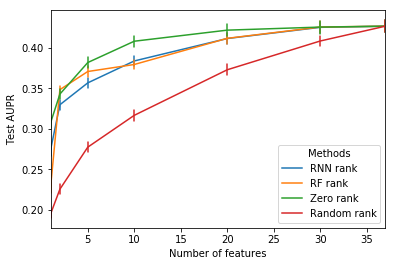

In [81]:
plot_figs(final_container, allow_method_names=['rf_rank_svc-rbf_aupr', 'rnn_rank_svc-rbf_aupr', 
                                              'random_rank_svc-rbf_aupr', 'zero_rank_svc-rbf_aupr'])

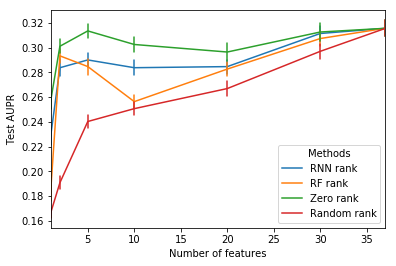

In [82]:
plot_figs(final_container, allow_method_names=['rf_rank_svc-linear_aupr', 'rnn_rank_svc-linear_aupr', 
                                               'random_rank_svc-linear_aupr', 'zero_rank_svc-linear_aupr'])

## Old

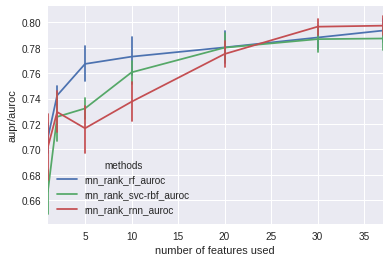

In [47]:
final_container.plot_figs(allow_method_names=['rnn_rank_rnn_auroc', 'rnn_rank_rf_auroc', 'rnn_rank_svc-rbf_auroc'])

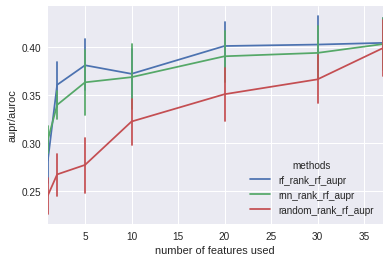

In [42]:
final_container.plot_figs(allow_method_names=['rf_rank_rf_aupr', 'rnn_rank_rf_aupr', 'random_rank_rf_aupr'])

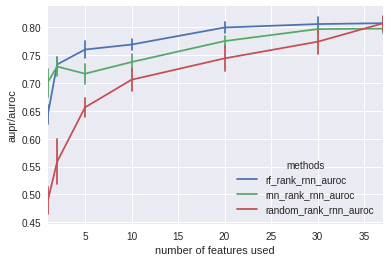

In [43]:
final_container.plot_figs(allow_method_names=['rf_rank_rnn_auroc', 'rnn_rank_rnn_auroc', 'random_rank_rnn_auroc'])

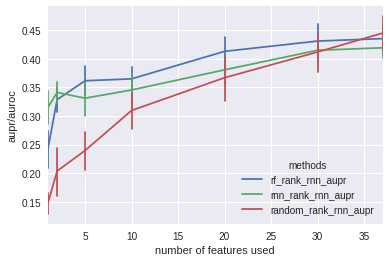

In [44]:
final_container.plot_figs(allow_method_names=['rf_rank_rnn_aupr', 'rnn_rank_rnn_aupr', 'random_rank_rnn_aupr'])

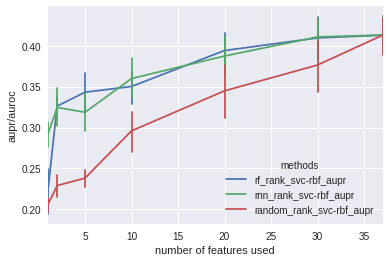

In [45]:
final_container.plot_figs(allow_method_names=['rf_rank_svc-rbf_aupr', 'rnn_rank_svc-rbf_aupr', 
                                              'random_rank_svc-rbf_aupr'])

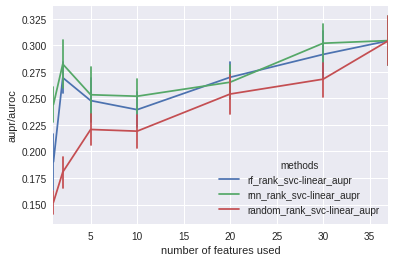

In [46]:
final_container.plot_figs(allow_method_names=['rf_rank_svc-linear_aupr', 'rnn_rank_svc-linear_aupr', 
                                              'random_rank_svc-linear_aupr'])

In [61]:
table = final_container.get_pandas_table()

In [67]:
table[(table['methods'] == 'rf_rank_rf_aupr') | (table['methods'] == 'rf_rank_rf_aupr')]

,aupr/auroc,number of features used,unit,methods
0,0.299443,1,0,rf_rank_rf_aupr
8,0.460692,2,0,rf_rank_rf_aupr
16,0.485243,5,0,rf_rank_rf_aupr
24,0.447234,10,0,rf_rank_rf_aupr
32,0.510593,20,0,rf_rank_rf_aupr
40,0.522696,30,0,rf_rank_rf_aupr
48,0.509201,37,0,rf_rank_rf_aupr
56,0.218928,1,1,rf_rank_rf_aupr
64,0.343758,2,1,rf_rank_rf_aupr
72,0.39559,5,1,rf_rank_rf_aupr
